In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Dataset Information:

This dataset consists of Monte Carlo (MC) generated data simulating high-energy gamma particle registration in a Cherenkov gamma telescope using imaging techniques. The telescope detects gamma rays by capturing the Cherenkov radiation emitted by charged particles formed in electromagnetic showers initiated by gamma interactions in the atmosphere.

The recorded data include pulses from Cherenkov photons impacting the photomultiplier tubes arranged in a plane (the camera). Depending on the gamma energy, anywhere from a few hundred to 10,000 photons are collected, forming a shower image that helps distinguish between gamma-initiated showers (signal) and hadronic showers caused by cosmic rays (background).

After pre-processing, the shower image generally appears as an elongated cluster, with its long axis pointing toward the camera center if the telescope is aligned with a point source. A principal component analysis (PCA) is performed to determine correlation axes and define an ellipse, aiding in classification. Features such as Hillas parameters, asymmetry along the major axis, and cluster extent further assist in discrimination.

The data was produced by the Monte Carlo simulation program Corsika, detailed in:

D. Heck et al., CORSIKA: A Monte Carlo Code to Simulate Extensive Air Showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68
Simulation parameters enabled the detection of events with **energies below 50 GeV

src:

[https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope]

# Data Preperation

In [58]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
url = "https://raw.githubusercontent.com/usernameneo/Data-Science-Projects/refs/heads/main/fcc-MAGIC/magic04.data"
df = pd.read_csv(url, names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [59]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [60]:
df["class"] = (df["class"] == "g").astype(int)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


Class Values
The only class values are either "g" for gamma particles or "h" for hadron particles. In order to assist in computation of our data, these will be converted to binary values, 0 for hadrons and 1 for gamma.

We will use the features of the DataFrame to determine wheather a recorded particle is a gamma or a hadron particle.

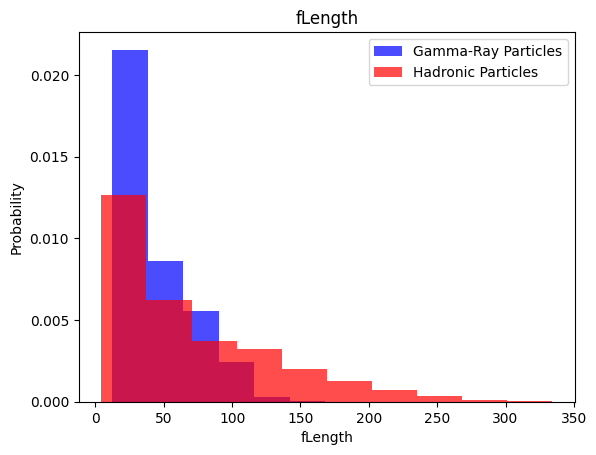

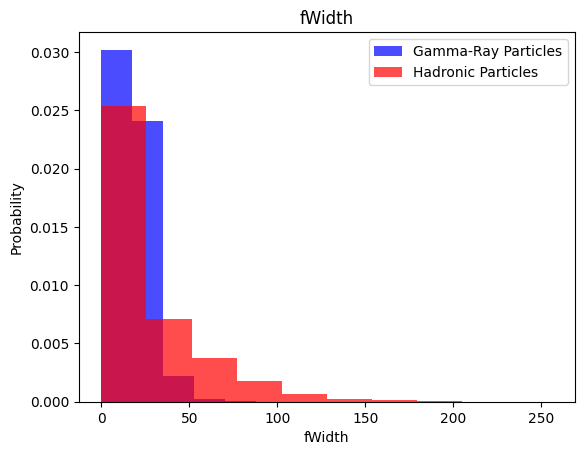

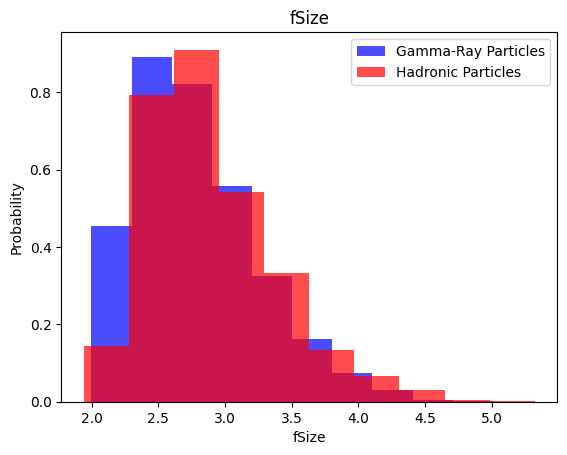

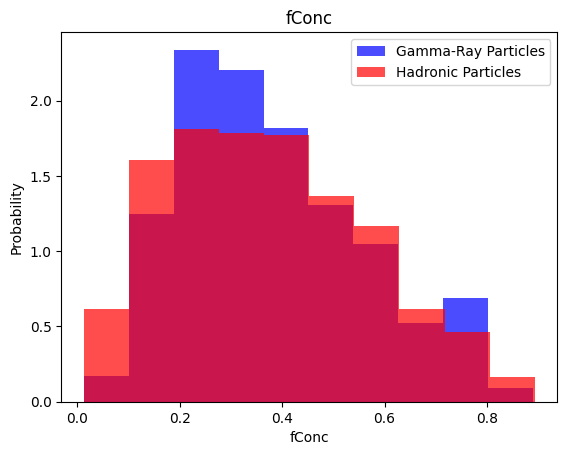

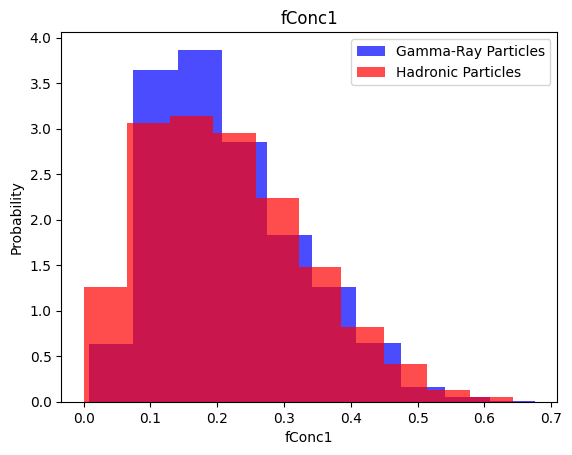

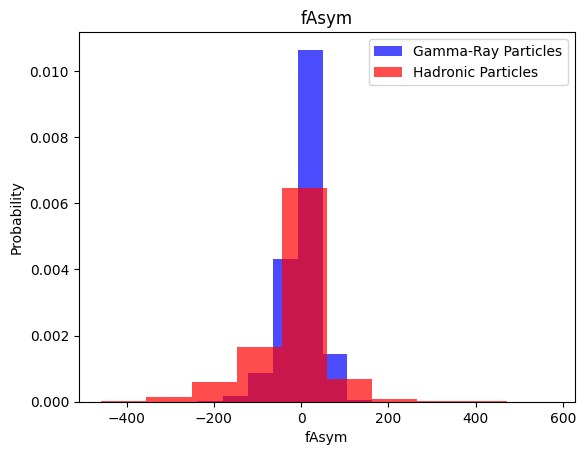

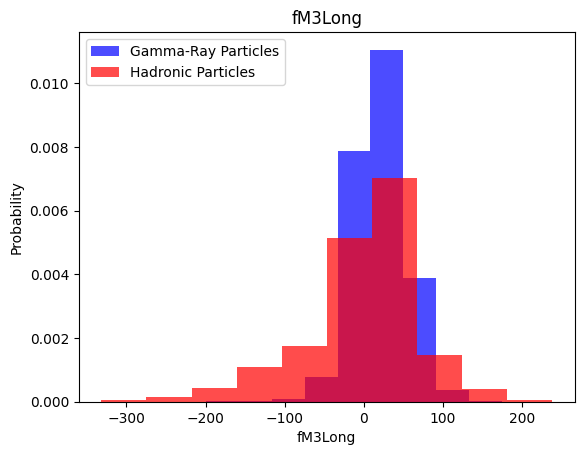

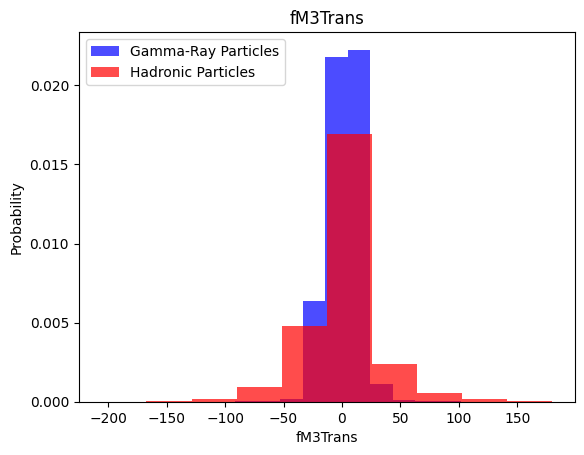

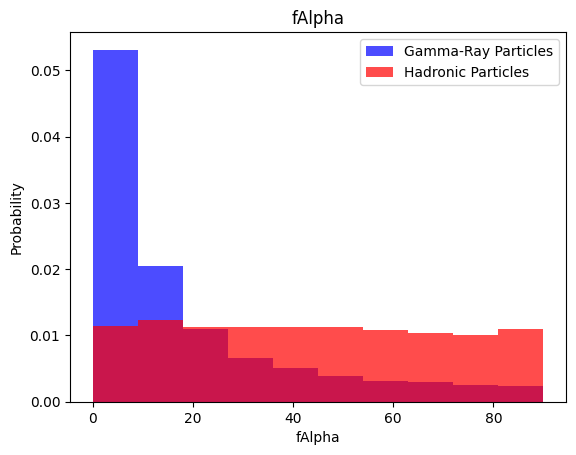

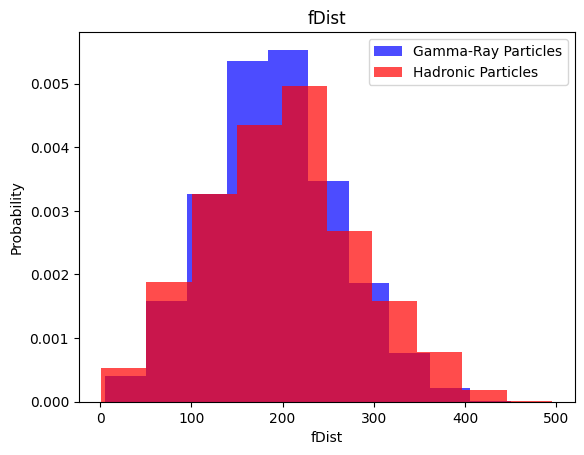

In [61]:
for col in cols[:-1]:
    plt.hist(df[df["class"]==1][col], color="blue", label="Gamma-Ray Particles", alpha=0.7, density=True)
    plt.hist(df[df["class"]==0][col], color="red", label="Hadronic Particles", alpha=0.7, density=True)
    plt.title(col)
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.legend()
    plt.show()

# Train, Validation and Test datasets

In [62]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/home/codespace/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [63]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [64]:
print("Gamma", len(train[train["class"]==1]))
print("Hadron:", len(train[train["class"]==0]))

Gamma 7416
Hadron: 3996


In [65]:
train, X_train, y_train = scale_dataset(train, oversample=True)
val, X_val, y_val = scale_dataset(val, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [66]:
print("Total:", len(y_train))
print("Gamma:", sum(y_train==1))
print("Hadron:", sum(y_train==0))

Total: 14832
Gamma: 7416
Hadron: 7416


# Classification Models

## K-Nearest Neighbors

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train)

y_predicts = knn_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      1316
           1       0.83      0.89      0.86      2488

    accuracy                           0.81      3804
   macro avg       0.79      0.77      0.78      3804
weighted avg       0.81      0.81      0.81      3804



## Naive Bayes

In [68]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

y_predicts = nb_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.65      0.40      0.49      1316
           1       0.74      0.89      0.81      2488

    accuracy                           0.72      3804
   macro avg       0.70      0.64      0.65      3804
weighted avg       0.71      0.72      0.70      3804



## Logistic Progression

In [69]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

y_predicts = lg_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1316
           1       0.84      0.80      0.82      2488

    accuracy                           0.77      3804
   macro avg       0.74      0.75      0.75      3804
weighted avg       0.77      0.77      0.77      3804



## Support Vector Machine

In [70]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_predicts = svm_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1316
           1       0.89      0.89      0.89      2488

    accuracy                           0.86      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.86      0.86      0.86      3804



# Deep Learning

## Neural Network